# Building and training neural networks using the Theano library

## Hello world with theano

In [ ]:
import theano
import theano.tensor as T

Construct two variables and a simple function
$$z = x^2+y^3$$

In [5]:
x = T.dscalar()
y = T.dscalar()
z = x**2 + y**3

In [6]:
z.eval({x:2,y:2})

array(12.0)

In [4]:
z.eval({x:3,y:1})


array(10.0)

## Computing derivatives with theano
The partial derivatives of the function above are
$$
\begin{align}
\frac{\partial z}{\partial x}  &= 2x \\
\frac{\partial z}{\partial y}  &= 3y^2
\end{align}
$$

We evaluate these for certain values of the inputs; e.g.
$$
\begin{align}
\left. \frac{\partial z}{\partial x} \right|_{\substack{x=2 \\ y=2}} = 4
\end{align}
$$

In [8]:
T.grad(z,x).eval({x:2,y:2})

array(4.0)

In [9]:
T.grad(z,x).eval({x:3,y:1})

array(6.0)

In [10]:
T.grad(z,y).eval({x:2,y:2})

array(12.0)

## Creating theano functions
Theano compiles the graph to C code every time we evaluate a variable.
For efficiency, we can create theano functions:

In [13]:
f = theano.function(inputs=[x, y], outputs = z)
f(2, 3)

array(31.0)

In [14]:
g = theano.function(inputs=[x, y], outputs = T.grad(z,x))
g(2,2)

array(4.0)

## Exercise 1
For
$$z = e^x y \log y$$
Create two theano functions, one to compute $z$ as a function of $x$ and $y$, and a second to compute $\left. \frac{\partial z}{\partial x}\right|_{x=1}$ as a function of $y$

In [15]:
# your code goes here ...

## Linear algebra with theano
Same as above, except that we declare our variables to be vectors or matrices. For the next example, we will use
$$ y = \boldsymbol{\textrm{x}}^\boldsymbol{\textrm{T}}\boldsymbol{\textrm{W}}\boldsymbol{\textrm{x}} $$
with partial derivatives
$$
\begin{align}
\frac{\partial y}{\partial \boldsymbol{\textrm{W}}}  &= \boldsymbol{\textrm{x}}\boldsymbol{\textrm{x}}^\boldsymbol{\textrm{T}} \\
\frac{\partial y}{\partial \boldsymbol{\textrm{x}}}  &= \boldsymbol{\textrm{x}}^\boldsymbol{\textrm{T}} \left( \boldsymbol{\textrm{W}} + \boldsymbol{\textrm{W}}^\boldsymbol{\textrm{T}}  \right) \\
\end{align}
$$

In [17]:
W = T.dmatrix()
x = T.dvector()
y = T.dot(x,T.dot(W,x))
param_dictionary = {W:[[1,0],[1,1]], x:[3,5]}
y.eval(param_dictionary)

array(49.0)

In [18]:
T.grad(y,W).eval(param_dictionary)

array([[  9.,  15.],
       [ 15.,  25.]])

In [19]:
T.grad(y,x).eval(param_dictionary)

array([ 11.,  13.])

## Theano shared variables
* We need these for model parameters
* Called "shared" because their value can be shared between multiple theano functions

In [20]:
from numpy import array
x = T.dvector()
a = theano.shared(value = array([2,3]))
y = T.dot(a, x)
y.eval({x:[5,7]})

array(31.0)

In [22]:
a.set_value(array([3,4]))
y.eval({x:[5,7]})

array(43.0)

## Theano <code>updates</code> and <code>givens</code>
<code>theano.function</code> has two other parameters that we will make use of: <code>updates</code> and <code>givens</code>.
* <code>updates</code>
  * Use this to update the model parameters
* <code>givens</code>
  * Use this to set the input and output variables to the values in our dataset

<code>updates</code>
* takes a list of pairs of the form <code>(shared_variable, new_expression)</code>
* after computing the function, it updates the values of the shared variables in the list
* we will use this to create a training function that takes a gradient descent step whenever we call it

In [24]:
x = T.dscalar()
a = theano.shared(value = 0)
f = theano.function(inputs=[x], outputs=a+x, updates=[[a,a+1]])
a.get_value()

array(0)

In [25]:
f(3) # updates the value of a

array(3.0)

In [27]:
a.get_value() # now gives a different result

array(1)

In [29]:
f(3) # this depends on a, so also gives a different result

array(5.0)

<code>givens</code>
* takes a dictionary of the form <code>{variable: value, ...}</code>
* when computing the function, it uses the given values for the corresponding variables instead
* we will use this as follows: 
  * we will have variables for the input and output of the model
  * when training, we will use <code>givens</code> to set both input and output to the desired values, when testing we will only set the input

In [31]:
x = T.dscalar()
y = T.dscalar()
f = theano.function(inputs=[x], outputs=x+y, givens = {y: 2*x})
f(3)

array(9.0)

# Digit recognition: MNIST dataset
## Logistic regression
Download Python gzipped pickle from: 
http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz

In [87]:
import gzip
import cPickle

f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

n_train, n_test = map(lambda x:len(x[0]), [train_set, test_set])
dims = train_set[0].shape[1]
n_classes = len(set(train_set[1]))

In [88]:
import numpy
import theano
import theano.tensor as T

prepare_data = lambda x: (theano.shared(x[0].astype('float64')), theano.shared(x[1].astype('int32')))
(training_x, training_y), (test_x, test_y) = map(prepare_data, [train_set, test_set])

In [89]:
X = T.dmatrix()
y = T.ivector()

W = theano.shared(numpy.zeros([dims,n_classes]))
b = theano.shared(numpy.zeros(n_classes))

In [90]:
y_hat = T.nnet.softmax(T.dot(X,W) + b)
y_pred = T.argmax(y_hat, axis=1)
test_error = T.mean(T.neq(y_pred, y))
training_error = -T.mean(T.log(y_hat)[T.arange(y.shape[0]), y])

In [91]:
learning_rate = .5
updates = [
        [W, W - learning_rate * T.grad(training_error, W)], 
        [b, b - learning_rate * T.grad(training_error, b)]
    ]

In [92]:
training_function = theano.function(
    inputs = [],
    outputs = training_error,
    updates = updates,
    givens = {X:training_x, y: training_y}
    )

In [93]:
test_function = theano.function(
    inputs = [],
    outputs = test_error,
    givens = {X: test_x, y: test_y}
    )

In [94]:
for i in range(5): # try range(300) for better results
    print('Training set negative log-likelihood: %f' % training_function())
    print('Test set accuracy: %f' % test_function())
    print('')

Training set negative log-likelihood: 2.302585
Test set accuracy: 0.318700

Training set negative log-likelihood: 1.839121
Test set accuracy: 0.211800

Training set negative log-likelihood: 1.525054
Test set accuracy: 0.213500

Training set negative log-likelihood: 1.314244
Test set accuracy: 0.183700

Training set negative log-likelihood: 1.168241
Test set accuracy: 0.181600



In [44]:
classify = theano.function(
    inputs = [],
    outputs = y_pred,
    givens = {X: test_x}
    )

In [47]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plot_mnist_digit(image):
    """ Plot a single MNIST image."""
    image = np.reshape(image, [28,28])    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

In [ ]:
test_labels = classify()

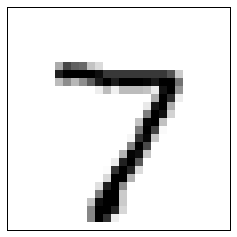

7 7


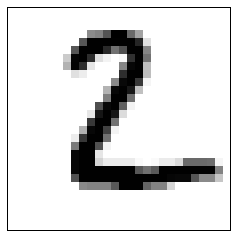

2 2


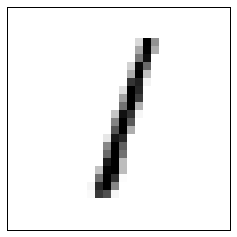

1 1


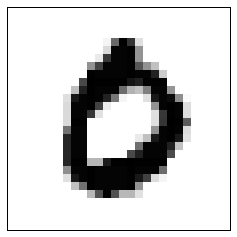

0 0


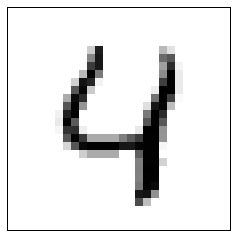

4 4


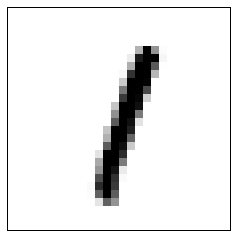

1 1


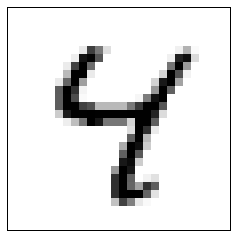

4 4


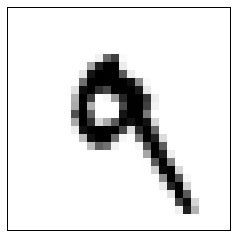

9 9


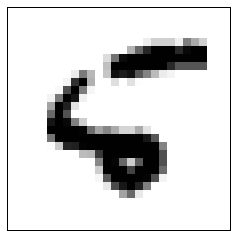

2 5


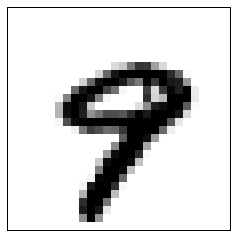

7 9


In [50]:
for i in range(10):
    plot_mnist_digit(test_x.get_value()[i])
    print test_labels[i], test_y.get_value()[i]

## Neural network with 1 hidden layer

In [84]:
n_hidden_neurons = 20
W_xh = theano.shared(.01*numpy.random.randn(dims,n_hidden_neurons))
b_xh = theano.shared(numpy.zeros(n_classes))
W_hy = theano.shared(numpy.zeros([n_hidden_neurons,n_classes]))
b_hy = theano.shared(numpy.zeros(n_classes))

In [66]:
h = T.tanh(T.dot(X,W_xh) + b_xh)
y_hat = T.nnet.softmax(T.dot(h,W_hy) + b_hy)

In [67]:
y_pred = T.argmax(y_hat, axis=1) # These stay the same, but in the notebook need to be re-run
test_error = T.mean(T.neq(y_pred, y))
training_error = -T.mean(T.log(y_hat)[T.arange(y.shape[0]), y])

In [81]:
learning_rate = 2
updates = [
        [W_xh, W_xh - learning_rate * T.grad(training_error, W_xh)], 
        [b_xh, b_xh - learning_rate * T.grad(training_error, b_xh)],
        [W_hy, W_hy - learning_rate * T.grad(training_error, W_hy)], 
        [b_hy, b_hy - learning_rate * T.grad(training_error, b_hy)],
    ]

In [83]:
# To run quickly, use smaller dataset...
f = gzip.open('C:/nnets/mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

train_set = (train_set[0][:5000], train_set[1][:5000])
test_set = (test_set[0][:5000], test_set[1][:5000])
# Need to re-run this in the notebook...
n_train, n_test = map(lambda x:len(x[0]), [train_set, test_set])
dims = train_set[0].shape[1]
n_classes = len(set(train_set[1]))

prepare_data = lambda x: (theano.shared(x[0].astype('float64')), theano.shared(x[1].astype('int32')))
training_x, training_y = prepare_data(train_set)
test_x, test_y = prepare_data(train_set)

## Exercise 2
Train and show results of this neural network (same way as we did for logistic regression)

In [74]:
# your code here ...

## Exercise 3
Add another hidden layer to the network, for a total of 4 layers (1 input, 1 output, 2 hidden).

**Bonus:** Write the code in an object-oriented manner so you can create dynamically as many hidden layers as you want

In [75]:
# your code here ...

# Optimization tricks
## Stochastic Gradient Descent
* Modify the training function so that it takes as input a vector of dataset indexes
  * Add this vector variable to the graph
* Write a function that takes the data, applies a random permutation, and splits into mini-batches
* Rewrite the training loop to use mini-batches
  * Can switch back to gradient descent by setting the mini-batch size to the size of the dataset

In [98]:
idx = T.ivector()
training_function = theano.function(
    inputs = [idx],
    outputs = training_error,
    updates = updates,
    givens = {X:training_x[idx], y: training_y[idx]}
    )
getMiniBatches = (lambda n, colLen: numpy.reshape(numpy.random.permutation(n)[:n//colLen*colLen], [n//colLen, colLen]))

In [99]:
minibatchSize = 600
for dataset_cycles in range(5):
    for minibatch_idx in getMiniBatches(n_train, minibatchSize):
        training_function(minibatch_idx)
    print('Test set accuracy: %f' % test_function())

Test set accuracy: 0.102300
Test set accuracy: 0.091000
Test set accuracy: 0.087900
Test set accuracy: 0.086100
Test set accuracy: 0.084100


## Early stopping

In [100]:
(training_x, training_y), (test_x, test_y), (validation_x, validation_y) = map(prepare_data, [train_set, test_set, valid_set])

validation_function = theano.function(
    inputs = [],
    outputs = test_error,
    givens = {X: validation_x, y: validation_y}
    )

In [101]:
nEpoch = 0
minEpochs = 50
patience = 0
maxPatience = 20

bestScore = numpy.inf
params = [W, b]

In [ ]:
while nEpoch < minEpochs or patience < maxPatience:
    for minibatch_idx in getMiniBatches(n_train, minibatchSize):
        training_function(minibatch_idx)
    validScore = validation_function()
    if validScore < bestScore:
        bestScore = validScore
        patience = 0
        bestParams = {i: i.get_value() for i in params}
    else: patience += 1
    nEpoch += 1

In [ ]:
for var, val in bestParams.iteritems():
    var.set_value(val)

## Parameter initialization
Only for weights going into a hidden layer

In [104]:
alpha = numpy.sqrt(6.0 / (dims + n_hidden_neurons))
W_xh = theano.shared(numpy.random.uniform(-alpha, alpha, (dims,n_hidden_neurons)))

## Momentum method

In [105]:
beta = .8
params = [W, b]
updates = []
for p in params:
    m = theano.shared(0.*p.get_value())
    updates += [(p, p - learning_rate * m),
                (m, beta * m + (1 - beta) * T.grad(training_error, p))]

## Whitening

In [107]:
def getWhiteningParameters(x):
    xMean = numpy.mean(x,axis=0)
    xBar = x-xMean
    sigma = numpy.dot(xBar.T, xBar) / x.shape[0]
    U,S,V = numpy.linalg.svd(sigma)
    epsilon = 1e-5
    nDims = sum(S > 1e-5)
    U = U[:,:nDims]
    S = S[:nDims]
    return xMean, U, S, epsilon

def whitenData(x, xMean, U, S, epsilon):
    xBar = x-xMean
    xRot = numpy.dot(xBar, U)
    xPCAwhite = 1./numpy.sqrt(S + epsilon) * xRot
    return xPCAwhite

In [ ]:
dims = whiteningParams[1].shape[1]
prepare_data = lambda x: (theano.shared(whitenData(x[0], *whiteningParams).astype('float64')), theano.shared(x[1].astype('int32')))

## Adaptive learning rates

In [ ]:
params = [W, b]
updates = []
ada_rates = {}
for p in params:
    ada_rates[p] = theano.shared(1.+0.*p.get_value())
    updates += [(p, p - learning_rate * ada_rates[p] * T.grad(training_error, p))]

training_function = theano.function(
    inputs = [idx],
    outputs = [training_error]+[T.grad(training_error, p) for p in params],
    updates = updates,
    givens = {X:training_x[idx], y: training_y[idx]}
    )

lastGradients = None; curGradients = None

# inside training loop
lastGradients = curGradients
        trFunOut = training_function(minibatch_idx)
        curGradients = dict(zip(params,trFunOut[1:]))
        if lastGradients is not None:
            for p in params:
                g = lastGradients[p] * curGradients[p]
                ar = numpy.copy(ada_rates[p].get_value())
                ar[g>0] += .05; ar[g<0] *= .95
                ada_rates[p].set_value(ar)

## rmsprop

In [109]:
beta = .9
params = [W, b]
updates = []
for p in params:
    ms = theano.shared(1.+0.*p.get_value())
    updates += [(p, p-learning_rate*T.grad(training_error, p)/T.sqrt(ms)),
       (ms, beta * ms + (1 - beta) * T.sqr(T.grad(training_error, p)))]

## Regularization (L1, L2)

In [110]:
L1 = 0; L2 = 0
for p in params:
    L1 += T.mean(abs(p))
    L2 += T.mean(p ** 2)

training_error = ((-T.mean(T.log(y_hat)[T.arange(y.shape[0]), y])) + .01 * L1 + .01 * L2)

## Dropout

In [112]:
# when constructing the network
drop_factor = .75
Wmask = theano.shared(numpy.zeros([dims,n_classes]))
y_hat = T.nnet.softmax(T.dot(X,W*Wmask) + b)

# before calling the training function
Wmask.set_value(numpy.random.binomial(1, drop_factor, W.get_value().shape))
# before calling the validation and test functions
Wmask.set_value(drop_factor * numpy.ones((W.get_value().shape)))

## Exercise 4
Fit the model using at least two of the methods above.
* Note that certain combinations are not straightforward; e.g. adaptive learning rate and momentum
* Not all methods are particularly good on all dataset; here I found that
  * Methods that worked well: SGD, early stopping, regularization
  * Methods that didn't work that well: Momentum, whitening, adapative learning rates, rmsprop, dropout

In [ ]:
# your code here, or better yet in a fresh notebook ...